In [1]:
!pip install folium 
! pip install geopy
! pip install beautifulsoup4


# 1. Scrap content from wiki page 

 Scrap content from wiki page

Import necessary packages.

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')

Scrape the "raw" table.

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Remove "\n" at the end of each string in the Neighborhood column

In [6]:
df["Neighborhood"] = df["Neighborhood"].str.replace("\n","")
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


##Group all neighborhoods with the same postal code

In [7]:
df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


# 2. Get the latitude and the longitude coordinates of each neighborhood.

We are not able to get the geohraphical coordinates of the neighborhoods using the Geocoder package, we use the given csv file instead

In [8]:
df_geo_coor = pd.read_csv("./Geospatial_Coordinates.csv")
df_geo_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We need to couple 2 dataframes "df" and "df_geo_coor" into one dataframe

In [9]:
df_toronto = pd.merge(df, df_geo_coor, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# 3. Explore and cluster the neighborhoods in Toronto

## 3.1. Get the latitude and longitude values of Toronto.

In [12]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


## 3.2. Create a map of the whole Toronto City with neighborhoods superimposed on top.

In [13]:
import folium 

In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

In [15]:
# "denc" = [D]owntown Toronto, [E]ast Toronto, [N]orth Toronto, [C]entral Toronto
df_toronto_denc = df_toronto[df_toronto['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto_denc.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
4,M4M,East Toronto,Studio District,43.659526,-79.340923


Add markers to the map.

In [16]:
for lat, lng, borough, neighborhood in zip(
        df_toronto['Latitude'], 
        df_toronto['Longitude'], 
        df_toronto['Borough'], 
        df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

##  3.4. Define Foursquare Credentials and Version

On the public repository on Github, I remove this field for the privacy!

In [17]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = ''

## 3.5. Explore the first neighborhood in our data frame "df_toronto"

In [18]:
neighborhood_name = df_toronto_denc.loc[0, 'Neighborhood']
print(f"The first neighborhood's name is '{neighborhood_name}'.")

The first neighborhood's name is 'The Beaches'.


Get the neighborhood's latitude and longitude values

In [19]:
neighborhood_latitude = df_toronto_denc.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto_denc.loc[0, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


## Now, let's get the top 100 venues that are in The Beaches within a radius of 500 meters.

In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()

In [21]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [23]:
CLIENT_ID = 'T1LUMOHYFVR21KSZSVKTKIFO1DPONRPOL4PGKBLWSYTPNDNV' # your Foursquare ID
CLIENT_SECRET = 'JBKZMRN5WS2PBXLZDUMMLCYJIDZELUNSSP3QKM51GSHXXWB0' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 500
#print(search_query + ' .... OK!')

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

Your credentails:
CLIENT_ID: T1LUMOHYFVR21KSZSVKTKIFO1DPONRPOL4PGKBLWSYTPNDNV
CLIENT_SECRET:JBKZMRN5WS2PBXLZDUMMLCYJIDZELUNSSP3QKM51GSHXXWB0


'https://api.foursquare.com/v2/venues/search?client_id=T1LUMOHYFVR21KSZSVKTKIFO1DPONRPOL4PGKBLWSYTPNDNV&client_secret=JBKZMRN5WS2PBXLZDUMMLCYJIDZELUNSSP3QKM51GSHXXWB0&ll=43.6534817,-79.3839347&v=20180604&radius=500&limit=100'

In [24]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [41]:

#Send the GET request and examine the results
results = requests.get(url).json()
results

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

<ipython-input-41-45219f05457d>:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet
0,5b193c42598e64002ca79b96,City of Toronto Civic Innovation Office,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1621511419,False,100 Queen St W,43.653454,-79.383952,"[{'label': 'display', 'lat': 43.653454, 'lng':...",3,M5H 2N2,CA,Toronto,ON,Canada,"[100 Queen St W, Toronto ON M5H 2N2, Canada]",NaN
1,4ad4c05ef964a5208ff620e3,Toronto City Hall,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1621511419,False,100 Queen St. W.,43.653140,-79.383967,"[{'label': 'display', 'lat': 43.65313989695342...",38,M5H 2N2,CA,Toronto,ON,Canada,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...",at Bay St.
2,4c41d47cd691c9b6fa4c8d0a,Kew Gardens Playground,"[{'id': '4bf58dd8d48988d1e7941735', 'name': 'P...",v-1621511419,False,Queen street and belfair ave,43.653225,-79.383185,"[{'label': 'display', 'lat': 43.65322456230742...",66,NaN,CA,Toronto,ON,Canada,"[Queen street and belfair ave, Toronto ON, Can...",NaN
3,4c093ee0340720a153728493,City Hall Council Chambers,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1621511419,False,NaN,43.651827,-79.383949,"[{'label': 'display', 'lat': 43.65182710471462...",184,NaN,CA,NaN,NaN,Canada,[Canada],NaN
4,4e4a878c52b11cf651b30044,Mayor Office Toronto,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",v-1621511419,False,100 Queen St. West,43.653367,-79.384021,"[{'label': 'display', 'lat': 43.653367, 'lng':...",14,M5H 2N2,CA,Toronto,ON,Canada,"[100 Queen St. West, Toronto ON M5H 2N2, Canada]",NaN


In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
toronto_denc_venues = getNearbyVenues(names=df_toronto_denc['Neighborhood'],
                                   latitudes=df_toronto_denc['Latitude'],
                                   longitudes=df_toronto_denc['Longitude']
                                  )

In [28]:
toronto_denc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Danforth East,43.685347,-79.338106,The Path,43.683923,-79.335007,Park


In [55]:
import matplotlib.pyplot as plt

In [42]:
import seaborn as sns 

In [50]:
toronto_denc_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,59,59,59,59,59,59
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,62,62,62,62,62,62
Christie,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35
Davisville North,11,11,11,11,11,11


In [52]:
 df4=toronto_denc_venues.groupby('Venue').count()

In [53]:
df4

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category
Venue,,,,,,
(The New) Moksha Yoga Bloor West,1,1,1,1,1,1
306 Yonge Street - Jordan Store,1,1,1,1,1,1
360 Restaurant,1,1,1,1,1,1
7 Numbers,1,1,1,1,1,1
7-Eleven,1,1,1,1,1,1
...,...,...,...,...,...,...
lululemon athletica,2,2,2,2,2,2
nodo,1,1,1,1,1,1
redpath avenue parkette,1,1,1,1,1,1


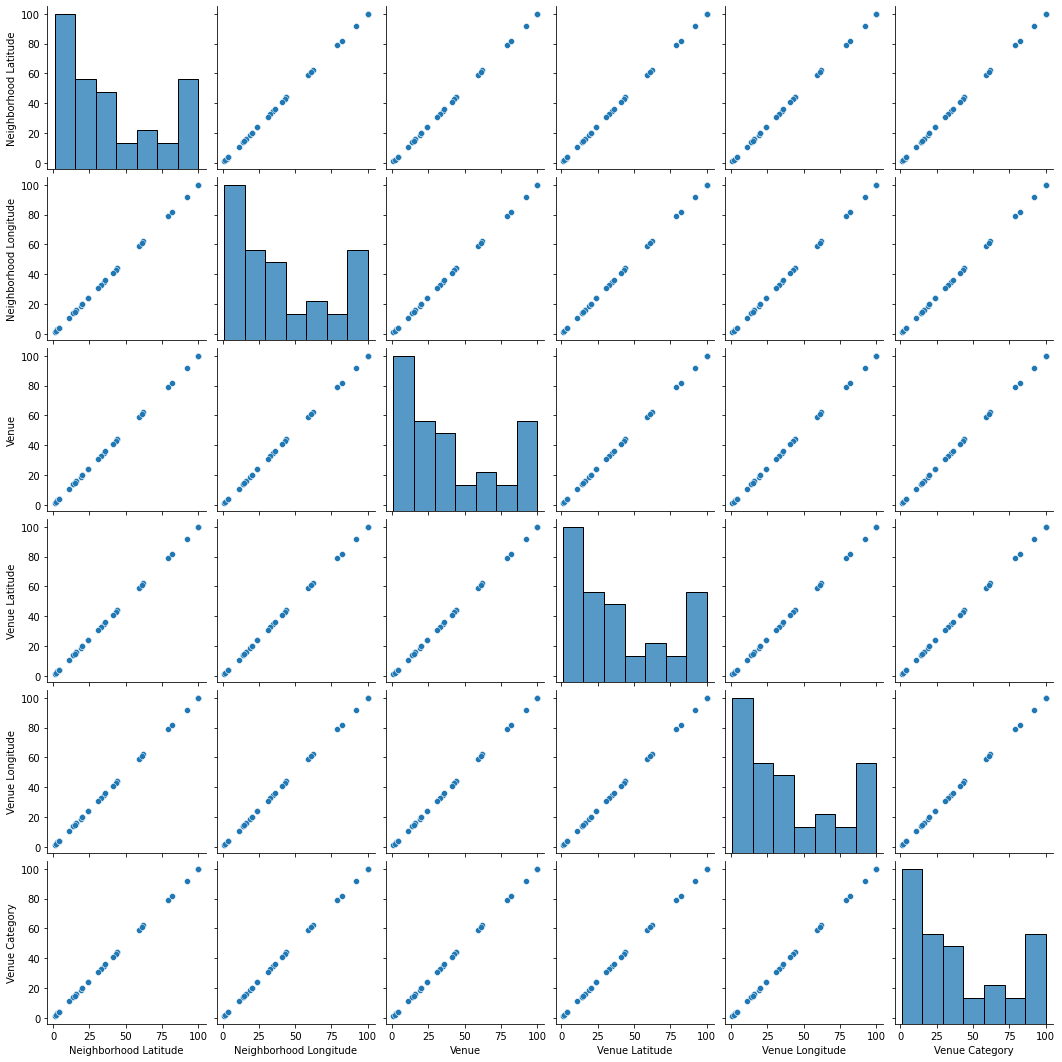

In [46]:
sns.pairplot(df3)

<AxesSubplot:xlabel='Neighborhood', ylabel='Count'>

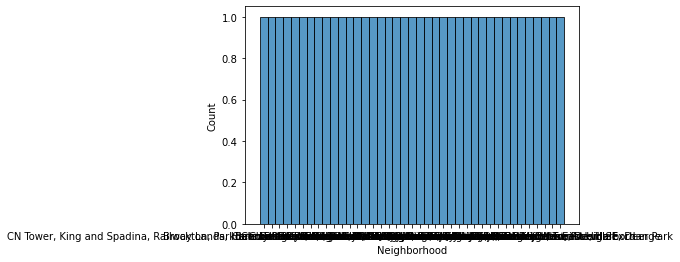

In [47]:
sns.histplot(data=df3, x="Neighborhood", binwidth=3)

### Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(toronto_denc_venues['Venue Category'].unique())))

There are 229 uniques categories.


In [31]:
# one hot encoding
toronto_denc_onehot = pd.get_dummies(toronto_denc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_denc_onehot['Neighborhood'] = toronto_denc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_denc_onehot.columns[-1]] + list(toronto_denc_onehot.columns[:-1])
toronto_denc_onehot = toronto_denc_onehot[fixed_columns]

toronto_denc_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
toronto_denc_grouped = toronto_denc_onehot.groupby('Neighborhood').mean().reset_index()
toronto_denc_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.0,0.071429,0.071429,0.142857,0.142857,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,Central Bay Street,0.016129,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.016129
4,Christie,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_denc_grouped['Neighborhood']

for ind in np.arange(toronto_denc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_denc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Restaurant,Pharmacy,Cheese Shop,Seafood Restaurant,Beer Bar,Farmers Market,Basketball Stadium
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Pet Store,Bar,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Sculpture Garden,Rental Car Location,Boutique,Plane,Harbor / Marina,Airport Food Court,Airport
3,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Japanese Restaurant,Thai Restaurant,Burger Joint,Bubble Tea Shop,Bank
4,Christie,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Restaurant,Baby Store,Athletics & Sports,Nightclub,Coffee Shop


In [34]:
# set number of clusters
kclusters = 5

toronto_denc_grouped_clustering = toronto_denc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_denc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_denc_merged = df_toronto_denc

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_denc_merged = toronto_denc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_denc_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Trail,Health Food Store,Pub,Wine Bar,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106,2,Park,Coffee Shop,Convenience Store,Metro Station,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Grocery Store,Fruit & Vegetable Store,Pub,Pizza Place,Lounge
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,2,Fast Food Restaurant,Park,Sandwich Place,Ice Cream Shop,Steakhouse,Pub,Sushi Restaurant,Italian Restaurant,Restaurant,Pizza Place
4,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Coffee Shop,Bakery,Gastropub,Brewery,Café,American Restaurant,Convenience Store,Seafood Restaurant,Bookstore,Cheese Shop


In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        toronto_denc_merged['Latitude'], 
        toronto_denc_merged['Longitude'], 
        toronto_denc_merged['Neighborhood'], 
        toronto_denc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [37]:
toronto_denc_merged.loc[toronto_denc_merged['Cluster Labels'] == 0, toronto_denc_merged.columns[[1] + list(range(5, toronto_denc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Downtown Toronto,0,Park,Trail,Playground,Deli / Bodega,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
24,Central Toronto,0,Park,Trail,Jewelry Store,Sushi Restaurant,Wine Bar,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [38]:
toronto_denc_merged.loc[toronto_denc_merged['Cluster Labels'] == 1, toronto_denc_merged.columns[[1] + list(range(5, toronto_denc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Central Toronto,1,Lawyer,Wine Bar,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [39]:
toronto_denc_merged.loc[toronto_denc_merged['Cluster Labels'] == 2, toronto_denc_merged.columns[[1] + list(range(5, toronto_denc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,2,Trail,Health Food Store,Pub,Wine Bar,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
1,East York/East Toronto,2,Park,Coffee Shop,Convenience Store,Metro Station,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
2,East Toronto,2,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Grocery Store,Fruit & Vegetable Store,Pub,Pizza Place,Lounge
3,East Toronto,2,Fast Food Restaurant,Park,Sandwich Place,Ice Cream Shop,Steakhouse,Pub,Sushi Restaurant,Italian Restaurant,Restaurant,Pizza Place
4,East Toronto,2,Coffee Shop,Bakery,Gastropub,Brewery,Café,American Restaurant,Convenience Store,Seafood Restaurant,Bookstore,Cheese Shop
6,Central Toronto,2,Hotel,Playground,Park,Food & Drink Shop,Gym / Fitness Center,Pizza Place,Breakfast Spot,Department Store,Sandwich Place,Dog Run
7,Central Toronto,2,Clothing Store,Coffee Shop,Grocery Store,Park,Shoe Store,Seafood Restaurant,Salon / Barbershop,Restaurant,Pet Store,Ice Cream Shop
8,Central Toronto,2,Dessert Shop,Sandwich Place,Pizza Place,Coffee Shop,Café,Italian Restaurant,Gym,Sushi Restaurant,Brewery,Diner
10,Central Toronto,2,Coffee Shop,Supermarket,Bagel Shop,Bank,Pub,Sushi Restaurant,Athletics & Sports,Fried Chicken Joint,Pizza Place,Restaurant
12,Downtown Toronto,2,Café,Coffee Shop,Park,Restaurant,Pub,Italian Restaurant,Bakery,Pizza Place,Grocery Store,Butcher


In [40]:
toronto_denc_merged.loc[toronto_denc_merged['Cluster Labels'] == 3, toronto_denc_merged.columns[[1] + list(range(5, toronto_denc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Central Toronto,3,Bus Line,Swim School,Park,Comfort Food Restaurant,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [41]:
toronto_denc_merged.loc[toronto_denc_merged['Cluster Labels'] == 4, toronto_denc_merged.columns[[1] + list(range(5, toronto_denc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,4,Garden,Music Venue,Wine Bar,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
